#### Data

TensorFlow example: https://www.tensorflow.org/io/tutorials/audio

Spectrogram from Example 1 : https://royalsocietypublishing.org/doi/10.1098/rsos.220158
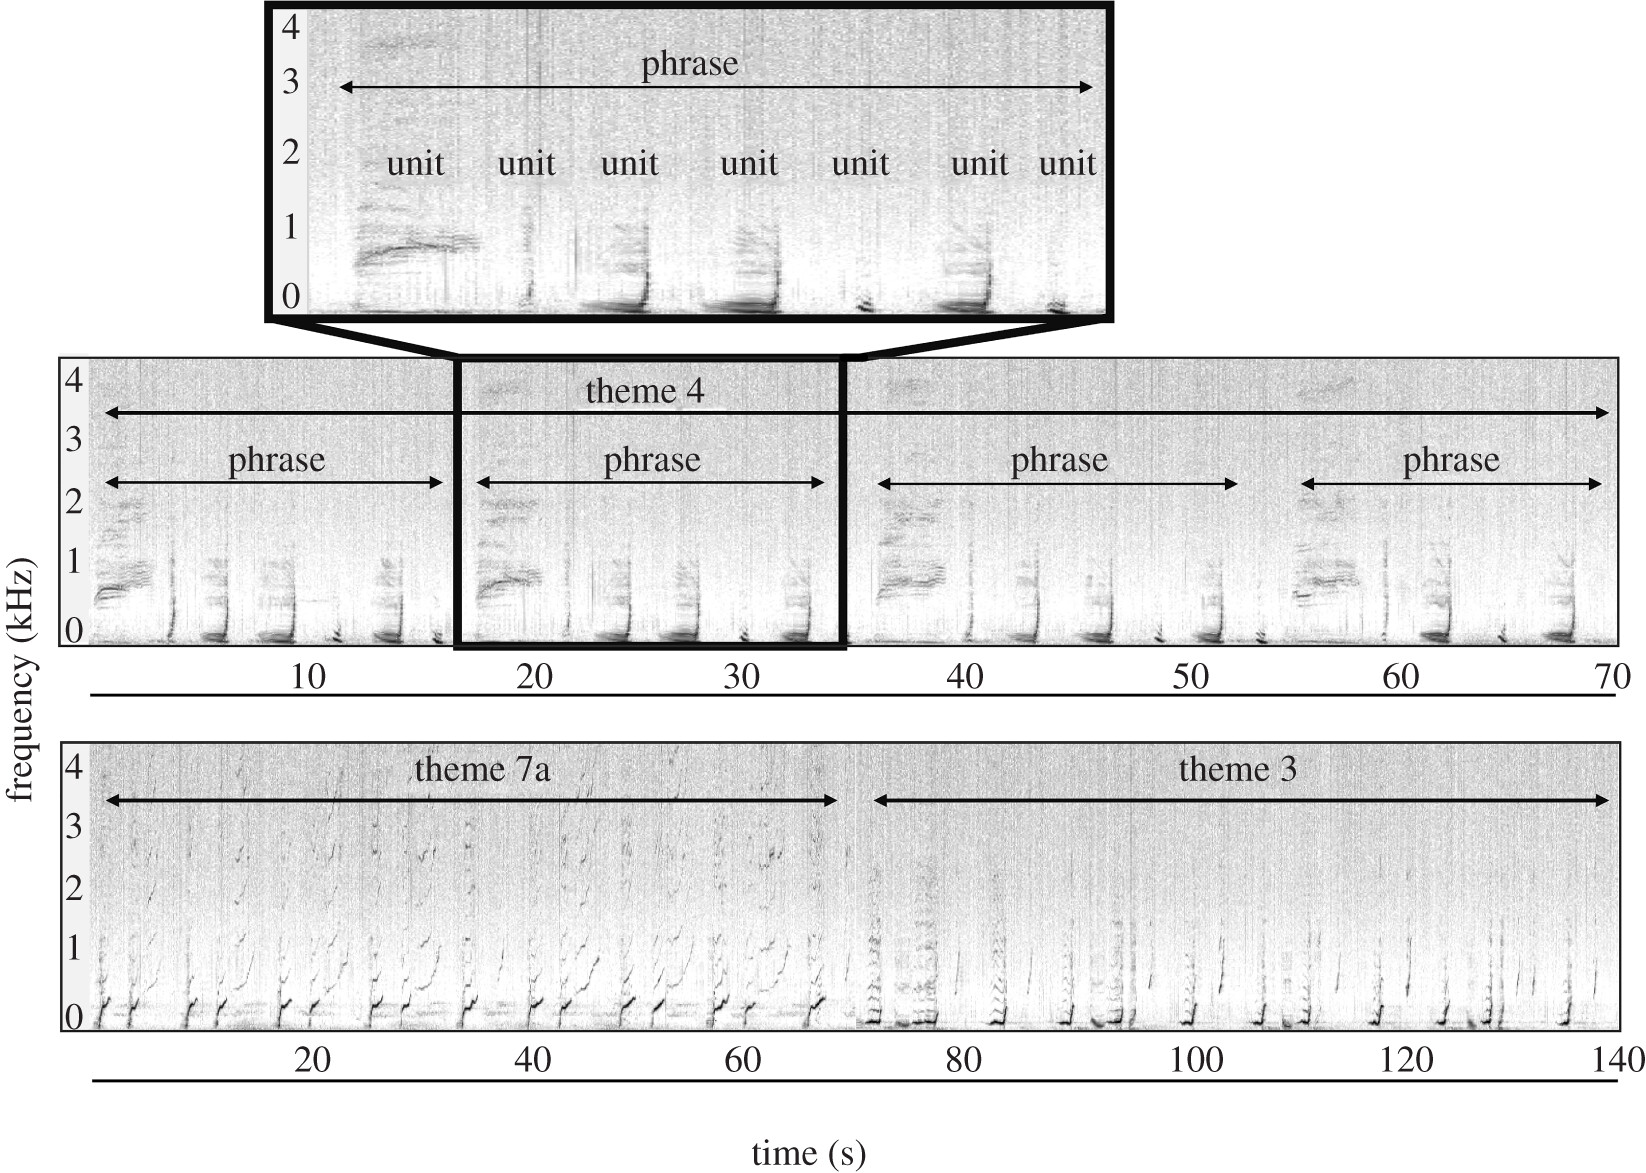

Audio Clip from Example 1: https://rs.figshare.com/articles/media/Audio_S1_from_Humpback_whale_song_revolutions_continue_to_spread_from_the_central_into_the_eastern_South_Pacific/20407689?backTo=/collections/Supplementary_material_from_Humpback_whale_song_revolutions_continue_to_spread_from_the_central_into_the_eastern_South_Pacific_/6125250


In [1]:
#Import libraries
import os
import pathlib

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

import tensorflow as tf
import tensorflow_io as tfio #collection of file systems/file formats that aren't available in TensorFlow's built-in support.

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

import librosa
import matplotlib.pyplot as plt
import os
import wave
import pylab
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
import tensorflow as tf
import tensorflow_io as tfio #collection of file systems/file formats that aren't available in TensorFlow's built-in support.

In [3]:
#sample audio clip from Garland study
#audio_clip = 'garlandaudioclip_1.wav'

In [4]:
audio_clip = 'Monterey_403406_52-Copy1.wav'

#### Setup

#### Read Audio File

- GCS (Google Cloud Storage), Flac, WAV, Ogg, MP3, and MP4A are supported by AudioIOTensor with automatic file format detection.
- AudioIOTensor is lazy-loaded so only shape, dtype, and sample rate are shown initially. The shape of the AudioIOTensor is represented as [samples, channels], which means the audio clip loaded is mono channel.

In [5]:
#class tfio.audio.AudioIOTensor reads audio file into a lazy-loaded IOTensor
audio = tfio.audio.AudioIOTensor(audio_clip)
print(audio)

<AudioIOTensor: shape=[480000      1], dtype=<dtype: 'int16'>, rate=16000>


- Content of audio clip is only read as needed, either by converting AudioIOTensor to Tensor through to_tensor(), or though slicing. Slicing is useful when only a small portion of a large audio clip is needed.

In [6]:
#creates tensor with shape (batch_size, length, channels)
audio_to_tensor = audio.to_tensor()
print(audio_to_tensor)

tf.Tensor(
[[-2052]
 [-2133]
 [-1921]
 ...
 [  688]
 [  470]
 [   75]], shape=(480000, 1), dtype=int16)


In [7]:
#audio_slice = audio[100:]
#print(audio_slice)

Using tf.squeeze to remove the last dimension (channel). This operation is often used when dealing with audio data represented as a 3D tensor, where the last dimension represents the number of audio channels. In many cases, the audio data is mono, meaning that there is only one channel, so the last dimension can be removed.

In [8]:
#creates shape (batch_size, length)
#with the last dimension (originally size 1) removed
audio_tensor = tf.squeeze(audio_to_tensor, axis=[-1])
print(audio_tensor)

tf.Tensor([-2052 -2133 -1921 ...   688   470    75], shape=(480000,), dtype=int16)


In [9]:
#play audio clip 
from IPython.display import Audio

Audio(audio_tensor.numpy(), rate=audio.rate.numpy())

Convert tensor into floats. Divide each value in the tensor by '32768.0' to normalize the audio tensor to a range of values between -1 and 1. '32768.0' is the maximum value that can be represented by a 16-bit signed integer, which is the most common format used to represent digital audio. Dividing each value by 32768.0 scales the range of the audio tensor to between -1 and 1.

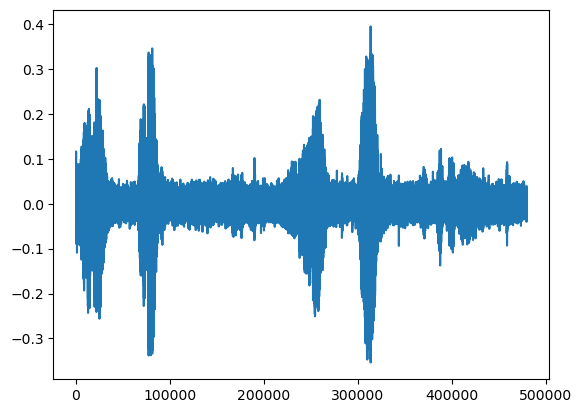

In [10]:
#Convert to float and normalize tensor 
#Show audio clip in graph
import matplotlib.pyplot as plt

tensor = tf.cast(audio_tensor, tf.float32) / 32768.0

plt.figure()
plt.plot(tensor.numpy())

#### Trim Noise

Trim noise from audio through API 'tfio.audio.trim'. API returns a pair of '[start, stop]' position of the segement.

tf.Tensor([    84 400372], shape=(2,), dtype=int64)
tf.Tensor(84, shape=(), dtype=int64) tf.Tensor(400372, shape=(), dtype=int64)
tf.Tensor([0.11660767 0.10284424 0.07736206 ... 0.07873535 0.08825684 0.10317993], shape=(400288,), dtype=float32)


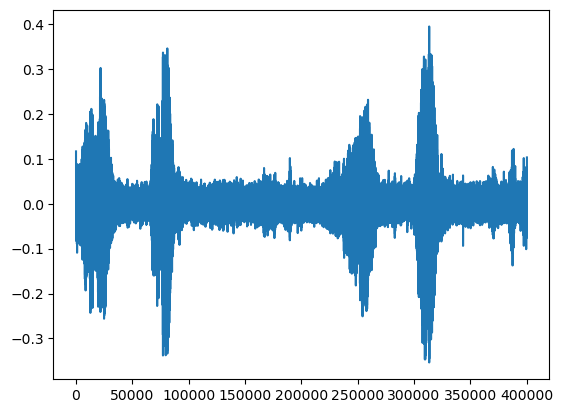

In [11]:
position = tfio.audio.trim(tensor, axis=0, epsilon=0.1)
print(position)

start = position[0]
stop = position[1]
print(start, stop)

processed = tensor[start:stop]
print(processed)

plt.figure()
plt.plot(processed.numpy())

#### Fade In/Out

'Fade' is an audio engineering technique, which gradually increases or decreases audio signals. This can be done through 'tfio.audio.fade', which supports different shapes of fades such as 'linear', 'logarithmic', or 'exponential'. 
- fate_in = Length of fade in (seconds)
    - the amplitude of the audio signal gradually increases from zero to the maximum value
- fade_out = Length of fade out (seconds)
    - the amplitude of the audio signal gradually decreases from the maximum value to zero

This is done so that the resulting audio signal starts and ends smoothly, rather than abruptly.

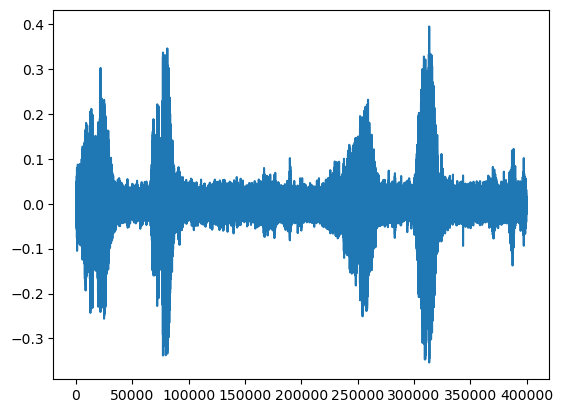

In [12]:
fade = tfio.audio.fade(
    processed, fade_in=1000, fade_out=2000, mode="logarithmic")

plt.figure()
plt.plot(fade.numpy())

#### Spectrogram
**Maybe explore different types?

**Optimize - nfft, *window*, stride
    - HANN window

Convert waveform to spectrogram with 'tfio.audio.spectrogram'. 

A spectrogram is a visual representation of the spectrum of frequencies in a signal as it varies with time. In order to create a spectrogram from an audio signal, the signal is typically divided into small, overlapping segments (or "windows"), and then a Fourier Transform is applied to each segment to obtain the frequency spectrum of that segment.


- tfio.audio.spectrogram(
    input, nfft, window, stride, name=None)
    - input = 1-D audio signal Tensor
    - nfft =  number of points to be used in Fourier Transform. 
      - increase nfft = higher frequency resolution, at cost of lower time resolution.
    - window = used to taper edges of the audio signal so they smoothly approach zero.
    - stride = size of hops between windows 
      - larger strides = less overlap & shorter spectrogram. 
      - smaller stride = more oeverlap & longer spectrogram)
    - name = name for operation (optional)

Choosing 'Stride'
- A stride equal to the window size, which means there is no overlap between adjacent windows.
- A stride equal to half of the window size, which means there is 50% overlap between adjacent windows.
- A stride equal to one-quarter of the window size, which means there is 75% overlap between adjacent windows.
- A stride equal to a single sample, which means the windows are tightly packed with maximum overlap. This is commonly used in tasks such as speech recognition.

Choosing 'NFFT'
- choose a nfft value that is a power of 2 and is large enough to capture the relevant frequency information in your signal. 
- A common value for speech analysis is 512, which is usually sufficient to capture formant frequencies.

Choosing 'Window'
- https://www.tensorflow.org/api_docs/python/tf/signal
- A good window should have a main lobe as narrow as possible to provide good frequency resolution, while at the same time having a low sidelobe level to minimize spectral leakage.
    - Rectangular window: has a constant value of one across the entire window. It has the worst spectral leakage and frequency resolution characteristics of all the windows.
    - Hamming window: has a main lobe that is wider than the main lobe of the rectangular window, but has lower sidelobes, providing better frequency resolution.
    - Hanning window: similar to the Hamming window, but with a different shape that results in a narrower main lobe and higher sidelobes.
    - Blackman window: has the lowest sidelobes of all the windows, providing the best spectral leakage characteristics. However, its main lobe is wider than the Hamming and Hanning windows, resulting in worse frequency resolution.
- In TensorFlow, the default window is the Hanning window, which is a good choice for most signals

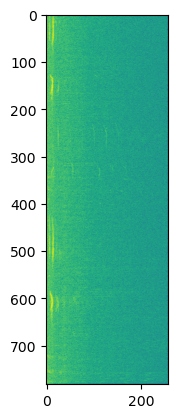

In [13]:
#No overlap b/w windows
spectrogram1 = tfio.audio.spectrogram(
    fade, nfft=512, window=512, stride=512)

plt.figure()
plt.imshow(tf.math.log(spectrogram1).numpy())

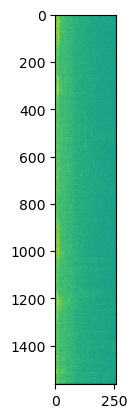

In [14]:
#50% overlap between adjacent windows
spectrogram2 = tfio.audio.spectrogram(
    fade, nfft=512, window=512, stride=256)

plt.figure()
plt.imshow(tf.math.log(spectrogram2).numpy())

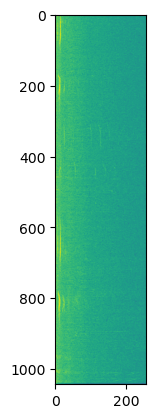

In [15]:
#75% overlap between adjacent windows
spectrogram3 = tfio.audio.spectrogram(
    fade, nfft=512, window=512, stride=384)

plt.figure()
plt.imshow(tf.math.log(spectrogram3).numpy())

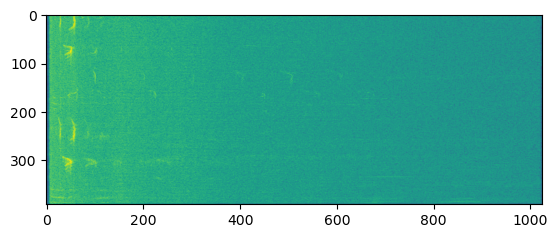

In [16]:
## USED IN GARLAND STUDY:
## fast Fourier transform 2048, Hann window, 50% overlap, 0–5 kHz & 20s increments
spectrogram4 = tfio.audio.spectrogram(
    fade, nfft=2048, window=2048, stride=1024)

plt.figure()
plt.imshow(tf.math.log(spectrogram4).numpy())

#### Mel-Spectrogram

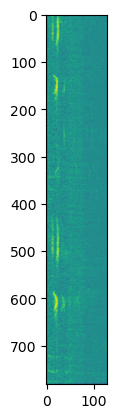

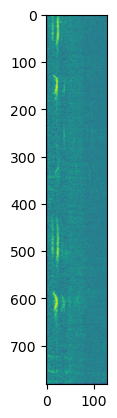

In [17]:
# Convert to mel-spectrogram for Spectrogram1 (No overlap b/w windows)
mel_spectrogram1 = tfio.audio.melscale(
    spectrogram1, rate=16000, mels=128, fmin=0, fmax=8000)


plt.figure()
plt.imshow(tf.math.log(mel_spectrogram1).numpy())

# Convert to db scale mel-spectrogram
dbscale_mel_spectrogram1 = tfio.audio.dbscale(
    mel_spectrogram1, top_db=80)

plt.figure()
plt.imshow(dbscale_mel_spectrogram1.numpy())

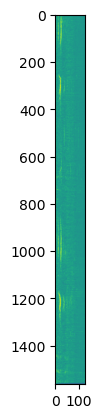

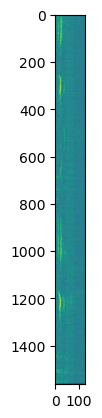

In [18]:
# Convert to mel-spectrogram for Spectrogram2 (#50% overlap between adjacent windows)
mel_spectrogram2 = tfio.audio.melscale(
    spectrogram2, rate=16000, mels=128, fmin=0, fmax=8000)


plt.figure()
plt.imshow(tf.math.log(mel_spectrogram2).numpy())

# Convert to db scale mel-spectrogram
dbscale_mel_spectrogram2 = tfio.audio.dbscale(
    mel_spectrogram2, top_db=80)

plt.figure()
plt.imshow(dbscale_mel_spectrogram2.numpy())

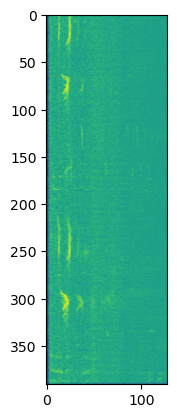

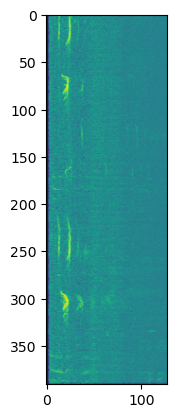

In [19]:
# Convert to mel-spectrogram for Spectrogram2 (GARLAND study)
mel_spectrogram4 = tfio.audio.melscale(
    spectrogram4, rate=16000, mels=128, fmin=0, fmax=8000)


plt.figure()
plt.imshow(tf.math.log(mel_spectrogram4).numpy())

# Convert to db scale mel-spectrogram
dbscale_mel_spectrogram4 = tfio.audio.dbscale(
    mel_spectrogram4, top_db=80)

plt.figure()
plt.imshow(dbscale_mel_spectrogram4.numpy())

#### Audio Data Augmentation 

#### Frequency Masking

-  encourage the model to be robust to missing frequency components in the input spectrogram, which can occur due to environmental factors or recording conditions.
- frequency channels [f0, f0 + f) are masked where f is chosen from a uniform distribution from 0 to the frequency mask parameter F, and f0 is chosen from (0, ν − f) where ν is the number of frequency channels.

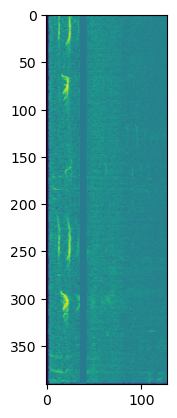

In [20]:
# Freq masking
freq_mask4 = tfio.audio.freq_mask(dbscale_mel_spectrogram4, param=10)

plt.figure()
plt.imshow(freq_mask4.numpy())

#### Time Masking
- t consecutive time steps [t0, t0 + t) are masked where t is chosen from a uniform distribution from 0 to the time mask parameter T, and t0 is chosen from [0, τ − t) where τ is the time steps.
- model can learn to be more robust to missing or noisy portions of the signal.

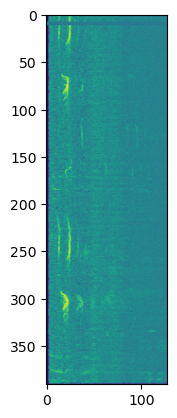

In [21]:
# Time masking
time_mask4 = tfio.audio.time_mask(dbscale_mel_spectrogram4, param=10)

plt.figure()
plt.imshow(time_mask4.numpy())

______________________________________________________

In [22]:
audio_hawaii = tfio.audio.AudioIOTensor('Cross_A_02_060203_071428.d20.x.flac')
print(audio_hawaii)

NotFoundError: {{function_node __wrapped__IO>AudioReadableInit_device_/job:localhost/replica:0/task:0/device:CPU:0}} Can not get size for: Cross_A_02_060203_071428.d20.x.flac : The system cannot find the file specified.
; No such file or directory [Op:IO>AudioReadableInit]

In [ ]:
#creates tensor with shape (batch_size, length, channels)
#audio_to_tensor = audio_hawaii.to_tensor()
#print(audio_to_tensor)

In [ ]:
audio_slice = audio_hawaii[100:]

# remove last dimension
audio_tensor = tf.squeeze(audio_slice, axis=[-1])

print(audio_tensor)

In [ ]:
from IPython.display import Audio

Audio(audio_tensor.numpy(), rate=audio.rate.numpy())

In [ ]:
import matplotlib.pyplot as plt

tensor = tf.cast(audio_tensor, tf.float32) / 32768.0
plt.figure()
plt.plot(tensor.numpy())

In [ ]:
position = tfio.audio.trim(tensor, axis=0, epsilon=0.1)
print(position)

start = position[0]
stop = position[1]
print(start, stop)

processed = tensor[start:stop]

plt.figure()
plt.plot(processed.numpy())

In [ ]:
fade = tfio.audio.fade(
    processed, fade_in=1000, fade_out=2000, mode="logarithmic")

plt.figure()
plt.plot(fade.numpy())

In [ ]:
#No overlap b/w windows
spectrogram1 = tfio.audio.spectrogram(
    fade, nfft=512, window=512, stride=512)

plt.figure()
plt.imshow(tf.math.log(spectrogram1).numpy())

In [ ]:
#50% overlap between adjacent windows
spectrogram2 = tfio.audio.spectrogram(
    fade, nfft=512, window=512, stride=256)

plt.figure()
plt.imshow(tf.math.log(spectrogram2).numpy())

In [ ]:
#75% overlap between adjacent windows
spectrogram3 = tfio.audio.spectrogram(
    fade, nfft=512, window=512, stride=384)

plt.figure()
plt.imshow(tf.math.log(spectrogram3).numpy())

In [ ]:
## USED IN GARLAND STUDY:
## fast Fourier transform 2048, Hann window, 50% overlap, 0–5 kHz & 20s increments
spectrogram4 = tfio.audio.spectrogram(
    fade, nfft=2048, window=2048, stride=1024)

plt.figure()
plt.imshow(tf.math.log(spectrogram4).numpy())

In [ ]:
# Convert to mel-spectrogram
mel_spectrogram1 = tfio.audio.melscale(
    spectrogram1, rate=16000, mels=128, fmin=0, fmax=8000)


plt.figure()
plt.imshow(tf.math.log(mel_spectrogram1).numpy())

# Convert to db scale mel-spectrogram
dbscale_mel_spectrogram1 = tfio.audio.dbscale(
    mel_spectrogram1, top_db=80)

plt.figure()
plt.imshow(dbscale_mel_spectrogram1.numpy())

In [ ]:
# Convert to mel-spectrogram
mel_spectrogram2 = tfio.audio.melscale(
    spectrogram2, rate=16000, mels=128, fmin=0, fmax=8000)


plt.figure()
plt.imshow(tf.math.log(mel_spectrogram2).numpy())

# Convert to db scale mel-spectrogram
dbscale_mel_spectrogram2 = tfio.audio.dbscale(
    mel_spectrogram2, top_db=80)

plt.figure()
plt.imshow(dbscale_mel_spectrogram2.numpy())

In [ ]:
# Convert to mel-spectrogram
mel_spectrogram3 = tfio.audio.melscale(
    spectrogram3, rate=16000, mels=128, fmin=0, fmax=8000)


plt.figure()
plt.imshow(tf.math.log(mel_spectrogram3).numpy())

# Convert to db scale mel-spectrogram
dbscale_mel_spectrogram3 = tfio.audio.dbscale(
    mel_spectrogram3, top_db=80)

plt.figure()
plt.imshow(dbscale_mel_spectrogram3.numpy())

In [ ]:
# Convert to mel-spectrogram
mel_spectrogram4 = tfio.audio.melscale(
    spectrogram4, rate=16000, mels=128, fmin=0, fmax=8000)


plt.figure()
plt.imshow(tf.math.log(mel_spectrogram4).numpy())

# Convert to db scale mel-spectrogram
dbscale_mel_spectrogram4 = tfio.audio.dbscale(
    mel_spectrogram4, top_db=80)

plt.figure()
plt.imshow(dbscale_mel_spectrogram4.numpy())

___________________________

### BEST Spectrogram model: nfft=512, window=512, stride=256

In [24]:
import tensorflow as tf
import tensorflow_io as tfio

audio = tfio.audio.AudioIOTensor(audio_clip)
print(audio)

audio_slice = audio[100:]

# remove last dimension
audio_tensor = tf.squeeze(audio_slice, axis=[-1])
print(audio_tensor)

from IPython.display import Audio
Audio(audio_tensor.numpy(), rate=audio.rate.numpy())

<AudioIOTensor: shape=[480000      1], dtype=<dtype: 'int16'>, rate=16000>
tf.Tensor([-1227 -1331 -1344 ...   688   470    75], shape=(479900,), dtype=int16)


tf.Tensor(
[-0.03744507 -0.0406189  -0.04101562 ...  0.02099609  0.01434326
  0.00228882], shape=(479900,), dtype=float32)


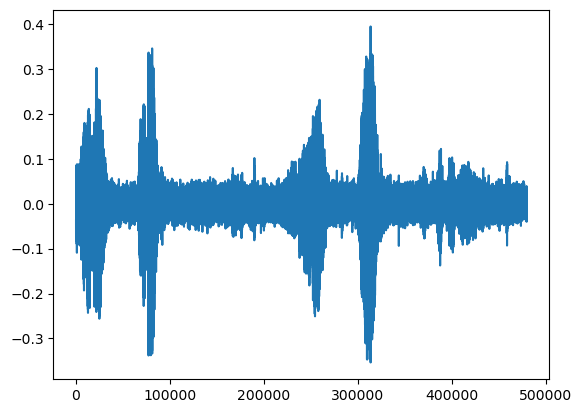

In [25]:
import matplotlib.pyplot as plt

tensor = tf.cast(audio_tensor, tf.float32) / 32768.0
print(tensor)
plt.figure()
plt.plot(tensor.numpy())

tf.Tensor([  5424 400272], shape=(2,), dtype=int64)
tf.Tensor(5424, shape=(), dtype=int64) tf.Tensor(400272, shape=(), dtype=int64)


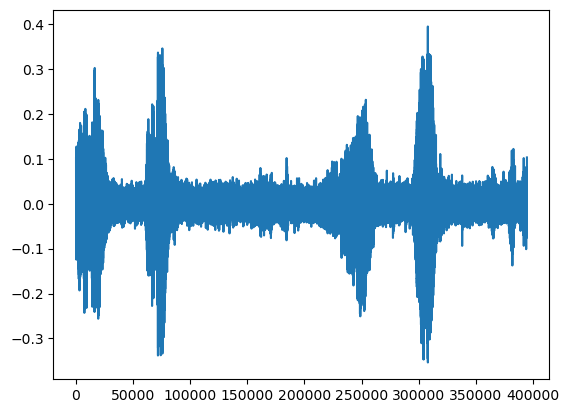

In [26]:
position = tfio.audio.trim(tensor, axis=0, epsilon=0.1)
print(position)

start = position[0]
stop = position[1]
print(start, stop)

if start == stop:
    print("No audio samples remaining after trimming.")
else:
    processed = tensor[start:stop]
    plt.figure()
    plt.plot(processed.numpy())

In [27]:
print("processed shape:", processed.shape)
print("processed values:", processed.numpy())

processed shape: (394848,)
processed values: [0.1015625  0.09335327 0.09082031 ... 0.07873535 0.08825684 0.10317993]
